# Setting the Seed for Reproducibility

In [13]:
import warnings
warnings.filterwarnings("ignore")

def set_seed(seed=123):
    import random
    import numpy as np
    import tensorflow as tf
    import warnings
    warnings.filterwarnings("ignore")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

SEED = 123
set_seed(SEED)


# Loading and Splitting the Data

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset and handle negative values
def load_data(file_path):
    data = pd.read_csv(file_path)
    
    # Handle negative and zero values before log transformation
    data['Current Assets'] = data['Current Assets'].apply(lambda x: x if x > 0 else np.nan)
    data['Total Liabilities'] = data['Total Liabilities'].apply(lambda x: x if x > 0 else np.nan)
    
    # Apply modified log transformation to highly skewed features
    def modified_log_transform(x):
        return np.sign(x) * np.log1p(np.abs(x))
    
    data['Current Assets'] = modified_log_transform(data['Current Assets'])
    data['Net Income'] = modified_log_transform(data['Net Income'])
    data['EBIT'] = modified_log_transform(data['EBIT'])
    data['Retained Earnings'] = modified_log_transform(data['Retained Earnings'])
    data['Total Liabilities'] = modified_log_transform(data['Total Liabilities'])
    
    # Drop rows with NaN values resulting from the log transformation
    data = data.dropna(subset=['Current Assets', 'Total Liabilities'])
    
    # Define features and target
    X = data.drop('Target', axis=1)
    y = data['Target']
    
    return X, y

# Split the data into training and test sets
def split_data(X, y, test_size=0.3, seed=123):
    return train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

# Define file path and load data
file_path = 'merged_bankruptcy_data.csv'
X, y = load_data(file_path)

# Split the data
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3, seed=123)

# Check the shapes of the datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Training set shape: (57476, 5)
Test set shape: (24633, 5)
Training set class distribution:
 Target
0    55069
1     2407
Name: count, dtype: int64
Test set class distribution:
 Target
0    23602
1     1031
Name: count, dtype: int64


# Handling the imbalance data

In [15]:
#apply oversampling using SMOTE to the training set
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the shape of the resampled training set
print("Resampled training set shape:", X_train_resampled.shape)
print("Resampled training set class distribution:\n", y_train_resampled.value_counts())



Resampled training set shape: (110138, 5)
Resampled training set class distribution:
 Target
0    55069
1    55069
Name: count, dtype: int64


# Evaluating the Model

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_test, y_test, y_pred, y_pred_prob):
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("ROC-AUC:", roc_auc)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(model, X_test, y_test, cv=cv, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Score:", cv_scores.mean())

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='Model (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    #plot the confusion matrix
    import seaborn as sns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


# Training and Evaluating Function

In [17]:
def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('classifier', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    evaluate_model(best_model, X_test, y_test, y_pred, y_pred_prob)
    return best_model


# Training and Evaluating a Random Forest Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Accuracy: 0.999878212154427
Precision: 0.998062015503876
Recall: 0.9990300678952473
F1 Score: 0.9985458070770722
ROC-AUC: 0.999995561703783
Confusion Matrix:
 [[23600     2]
 [    1  1030]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99979704 0.99878222 0.99979704 0.999797   0.999797  ]
Mean Cross-Validation Score: 0.9995940569917219


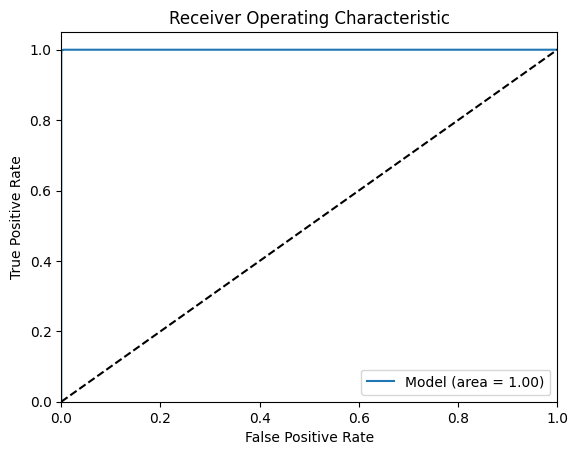

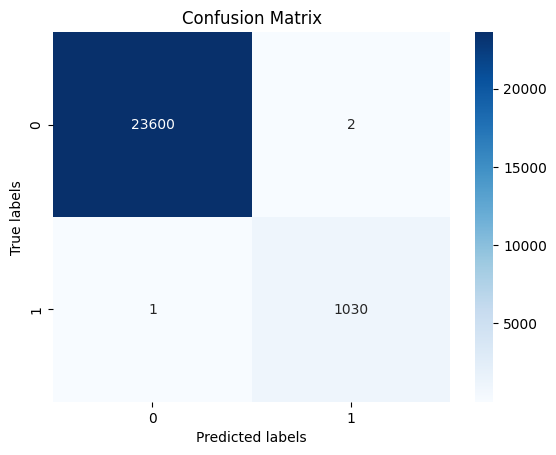

In [18]:
from sklearn.ensemble import RandomForestClassifier

set_seed(SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
rf_model = train_and_evaluate_model(rf_model, rf_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a Support Vector Machine (SVM) Classifier

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Accuracy: 0.999756424308854
Precision: 0.9942140790742526
Recall: 1.0
F1 Score: 0.9970986460348162
ROC-AUC: 0.999959253975008
Confusion Matrix:
 [[23596     6]
 [    0  1031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.99      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99979704 0.99918815 0.99979704 0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.999634641403962


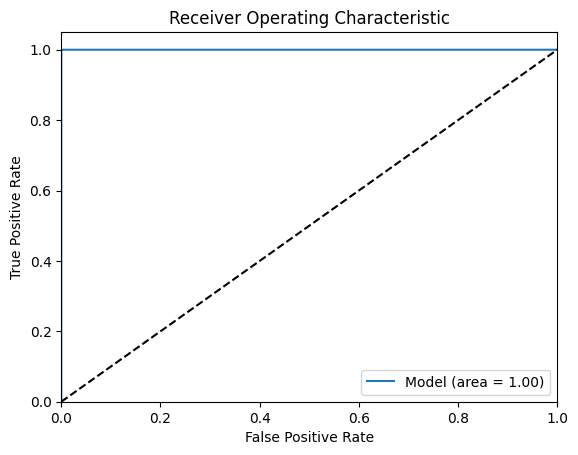

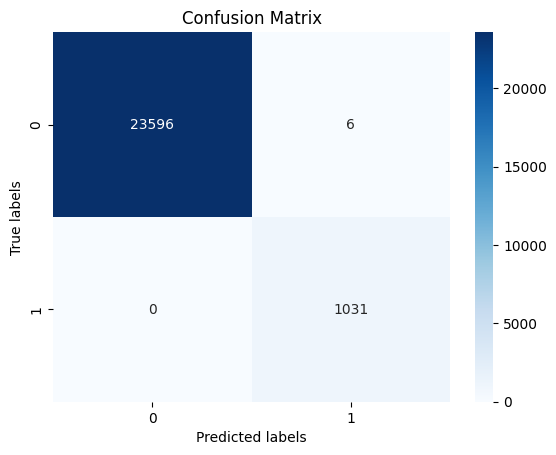

In [19]:
from sklearn.svm import SVC

set_seed(SEED)
svm_model = SVC(probability=True, random_state=SEED)
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}
svm_model = train_and_evaluate_model(svm_model, svm_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a Gradient Boosting Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Accuracy: 0.999756424308854
Precision: 0.9951690821256038
Recall: 0.9990300678952473
F1 Score: 0.9970958373668926
ROC-AUC: 0.9999836440565337
Confusion Matrix:
 [[23597     5]
 [    1  1030]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99898518 1.         0.99959399 0.999797  ]
Mean Cross-Validation Score: 0.9995940487512319


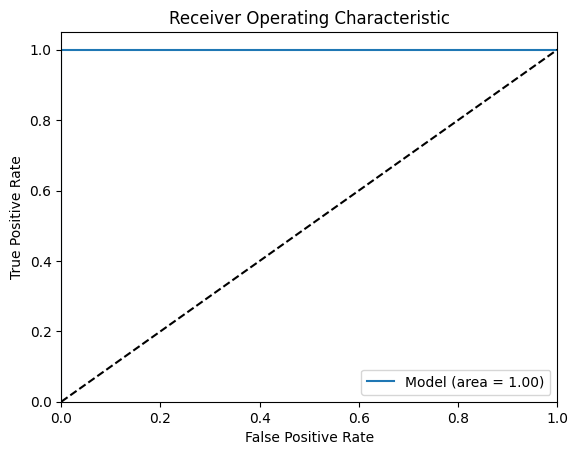

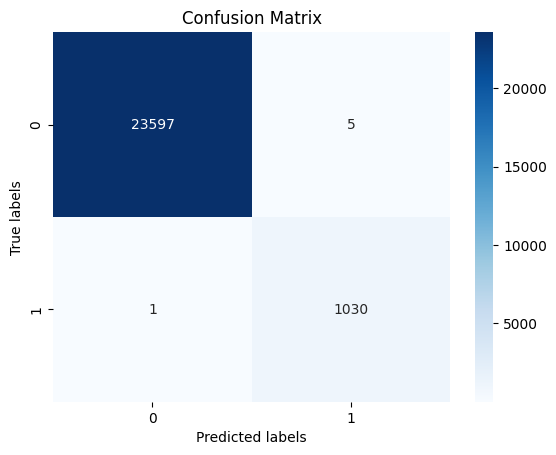

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

set_seed(SEED)
gb_model = GradientBoostingClassifier(random_state=SEED)
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
gb_model = train_and_evaluate_model(gb_model, gb_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating an XGBoost Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Accuracy: 0.999634636463281
Precision: 0.9932432432432432
Recall: 0.9980601357904947
F1 Score: 0.9956458635703919
ROC-AUC: 0.9999978219472269
Confusion Matrix:
 [[23595     7]
 [    2  1029]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.99      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99878222 1.         0.99939099 0.999797  ]
Mean Cross-Validation Score: 0.9995128552052825


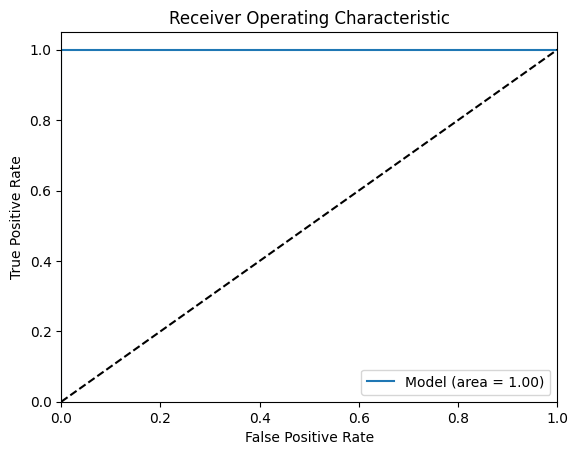

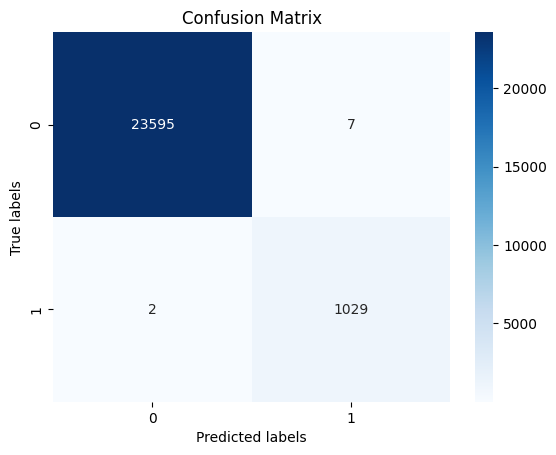

In [21]:
from xgboost import XGBClassifier

set_seed(SEED)
xgb_model = XGBClassifier(random_state=SEED)
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
xgb_model = train_and_evaluate_model(xgb_model, xgb_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a CatBoost Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.3728332	total: 149ms	remaining: 29.7s
1:	learn: 0.1976785	total: 162ms	remaining: 16s
2:	learn: 0.1049106	total: 174ms	remaining: 11.4s
3:	learn: 0.0603707	total: 187ms	remaining: 9.15s
4:	learn: 0.0336588	total: 199ms	remaining: 7.78s
5:	learn: 0.0205452	total: 211ms	remaining: 6.82s
6:	learn: 0.0129535	total: 224ms	remaining: 6.16s
7:	learn: 0.0089084	total: 235ms	remaining: 5.64s
8:	learn: 0.0061590	total: 248ms	remaining: 5.26s
9:	learn: 0.0042789	total: 260ms	remaining: 4.94s
10:	learn: 0.0033691	total: 272ms	remaining: 4.68s
11:	learn: 0.0026855	total: 285ms	remaining: 4.47s
12:	learn: 0.0022251	total: 298ms	remaining: 4.28s
13:	learn: 0.0018700	total: 309ms	remaining: 4.1s
14:	learn: 0.0016730	total: 321ms	remaining: 3.96s
15:	learn: 0.0014015	total: 334ms	remaining: 3.84s
16:	learn: 0.0011632	total: 346ms	remaining: 3.73s
17:	learn: 0.0010597	total: 359ms	remaining: 3.63s
18:	learn: 0.0009454	total: 372ms

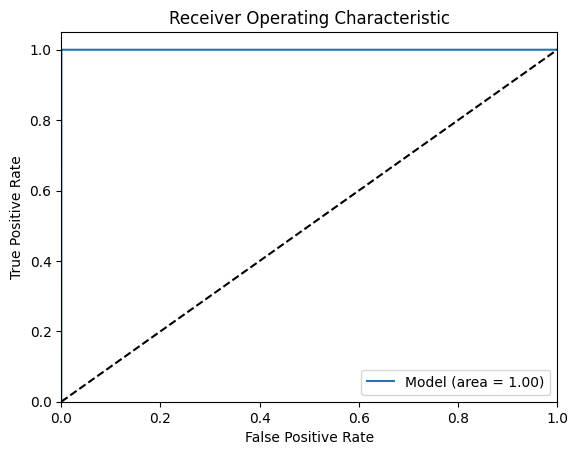

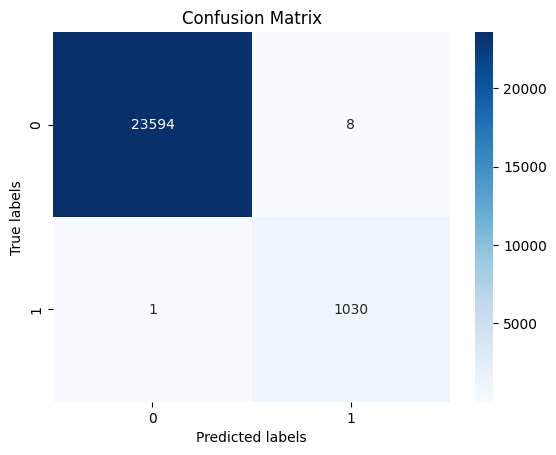

In [22]:
from catboost import CatBoostClassifier

set_seed(SEED)
catboost_model = CatBoostClassifier(random_state=SEED)
catboost_param_grid = {
    'classifier__iterations': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [3, 5, 7]
}
catboost_model = train_and_evaluate_model(catboost_model, catboost_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a K-Nearest Neighbors (KNN) Classifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Accuracy: 0.999756424308854
Precision: 0.9942140790742526
Recall: 1.0
F1 Score: 0.9970986460348162
ROC-AUC: 0.9998728921277857
Confusion Matrix:
 [[23596     6]
 [    0  1031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.99      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99878222 0.99979704 0.99918798 0.999797  ]
Mean Cross-Validation Score: 0.9994316616593331


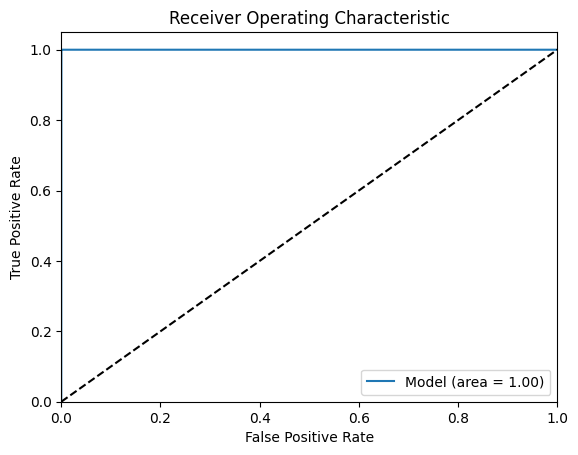

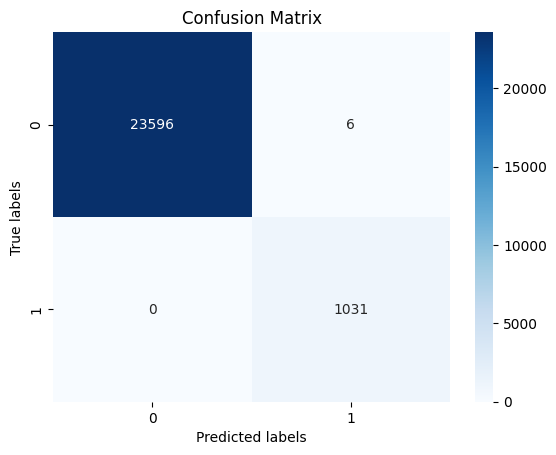

In [23]:
from sklearn.neighbors import KNeighborsClassifier

set_seed(SEED)
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}
knn_model = train_and_evaluate_model(knn_model, knn_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a Naive Bayes Classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'classifier__var_smoothing': 1e-09}
Accuracy: 0.9980107985223075
Precision: 0.9667300380228137
Recall: 0.9864209505334627
F1 Score: 0.9764762361977917
ROC-AUC: 0.9998908918846658
Confusion Matrix:
 [[23567    35]
 [   14  1017]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.97      0.99      0.98      1031

    accuracy                           1.00     24633
   macro avg       0.98      0.99      0.99     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99715851 0.99918815 0.99776695 0.99756395]
Mean Cross-Validation Score: 0.9982543264013509


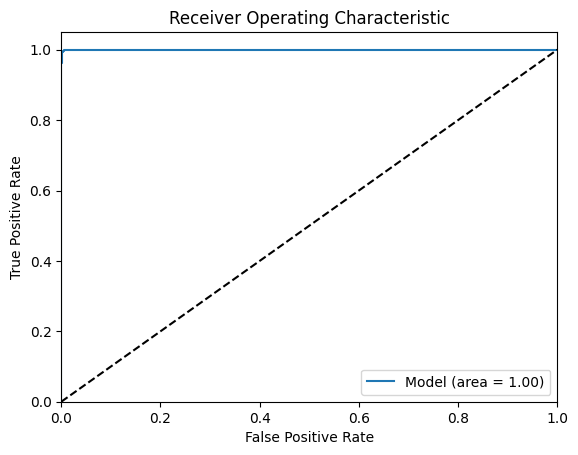

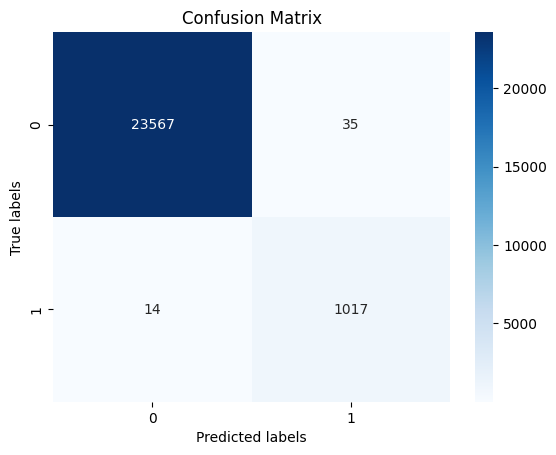

In [24]:
from sklearn.naive_bayes import GaussianNB

set_seed(SEED)
nb_model = GaussianNB()
nb_param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
}
nb_model = train_and_evaluate_model(nb_model, nb_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a Logistic Regression Classifier

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'classifier__C': 1, 'classifier__solver': 'saga'}
Accuracy: 0.9954532537652743
Precision: 0.9020122484689413
Recall: 1.0
F1 Score: 0.9484820607175714
ROC-AUC: 0.9994557744740599
Confusion Matrix:
 [[23490   112]
 [    0  1031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       0.90      1.00      0.95      1031

    accuracy                           1.00     24633
   macro avg       0.95      1.00      0.97     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99817333 0.99573777 0.99837629 0.99796996 0.99715794]
Mean Cross-Validation Score: 0.9974830577589939


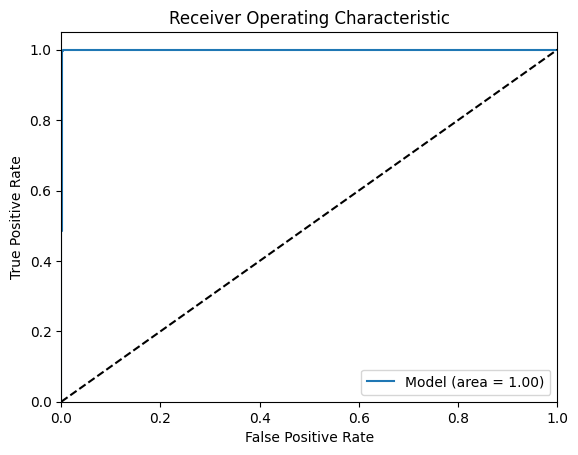

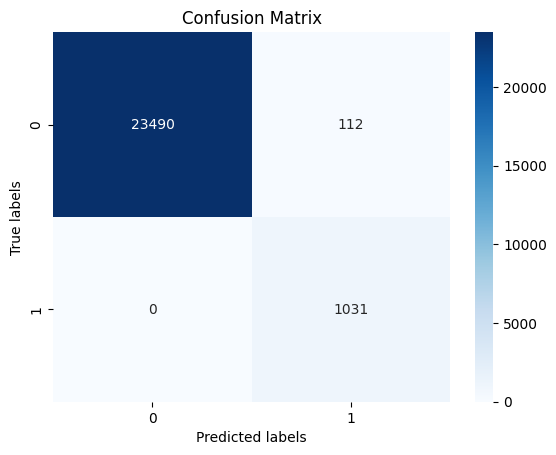

In [25]:
from sklearn.linear_model import LogisticRegression

set_seed(SEED)
lr_model = LogisticRegression(random_state=SEED, max_iter=10000)
lr_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}
lr_model = train_and_evaluate_model(lr_model, lr_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)


# Training and Evaluating a linear discriminant analysis Classifier

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'classifier__n_components': None, 'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr', 'classifier__tol': 0.0001}
Accuracy: 0.8719197824057159
Precision: 0.24629718107978976
Recall: 1.0
F1 Score: 0.39524631013992717
ROC-AUC: 0.9984537469124047
Confusion Matrix:
 [[20447  3155]
 [    0  1031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93     23602
           1       0.25      1.00      0.40      1031

    accuracy                           0.87     24633
   macro avg       0.62      0.93      0.66     24633
weighted avg       0.97      0.87      0.91     24633

Cross-Validation Scores: [0.95839253 0.95940735 0.95818957 0.9589931  0.95879009]
Mean Cross-Validation Score: 0.9587545274280995


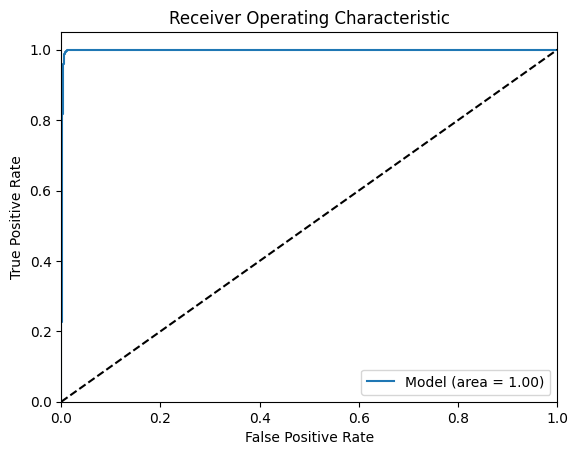

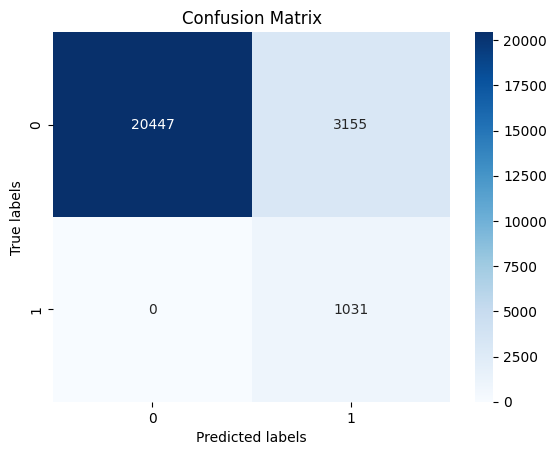

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

set_seed(SEED)
lda_model = LinearDiscriminantAnalysis()
lda_param_grid = {
    'classifier__solver': ['svd', 'lsqr', 'eigen'],
    'classifier__shrinkage': ['auto', None],
    'classifier__n_components': [None, 1, 2],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}
lda_model = train_and_evaluate_model(lda_model, lda_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)

# Training and Evaluating a Decision Tree Classifier

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Accuracy: 0.999756424308854
Precision: 0.9980563654033042
Recall: 0.9961202715809894
F1 Score: 0.9970873786407767
ROC-AUC: 0.9980177664997565
Confusion Matrix:
 [[23600     2]
 [    4  1027]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99898518 0.99837629 0.99979704 0.99959399 0.99959399]
Mean Cross-Validation Score: 0.9992692992889033


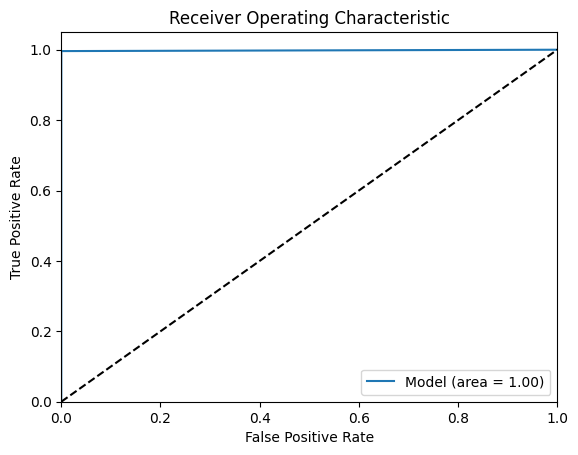

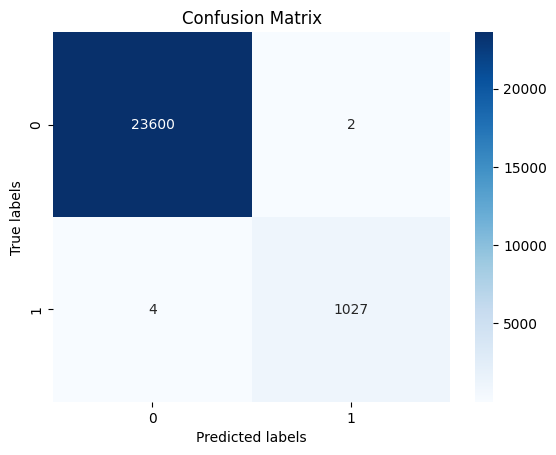

In [27]:
from sklearn.tree import DecisionTreeClassifier

set_seed(SEED)
dt_model = DecisionTreeClassifier(random_state=SEED)
dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
dt_model = train_and_evaluate_model(dt_model, dt_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)

# Training and Evaluating a AdaBoost Classifier

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__n_estimators': 200}
Accuracy: 0.9997158283603297
Precision: 0.995164410058027
Recall: 0.9980601357904947
F1 Score: 0.9966101694915255
ROC-AUC: 0.9996124298923853
Confusion Matrix:
 [[23597     5]
 [    2  1029]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23602
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     24633
   macro avg       1.00      1.00      1.00     24633
weighted avg       1.00      1.00      1.00     24633

Cross-Validation Scores: [0.99959407 0.99939111 1.         0.99939099 0.999797  ]
Mean Cross-Validation Score: 0.999634633163472


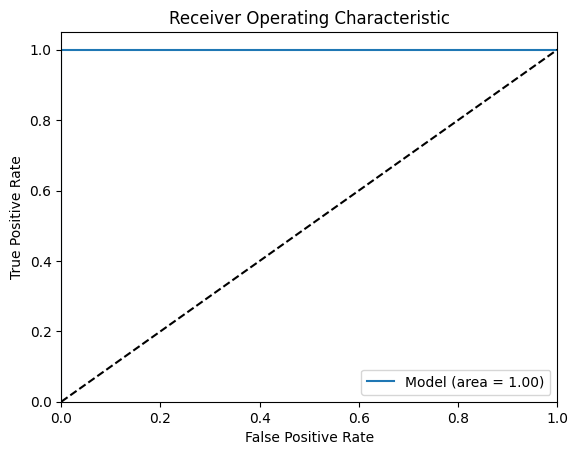

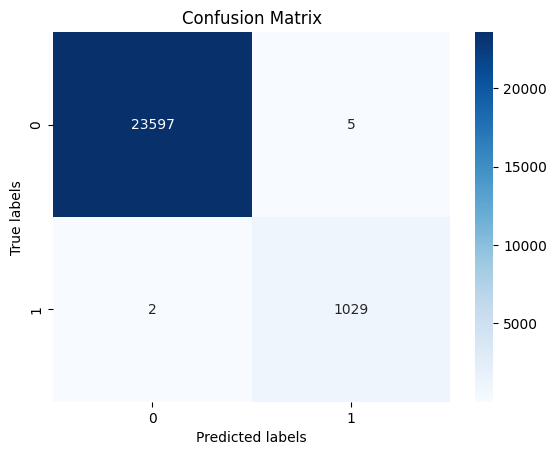

In [28]:
from sklearn.ensemble import AdaBoostClassifier

set_seed(SEED)
ada_model = AdaBoostClassifier(random_state=SEED)
ada_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}
ada_model = train_and_evaluate_model(ada_model, ada_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)

# Training and Evaluating a Lightgbm Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55069, number of negative: 55069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 110138, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

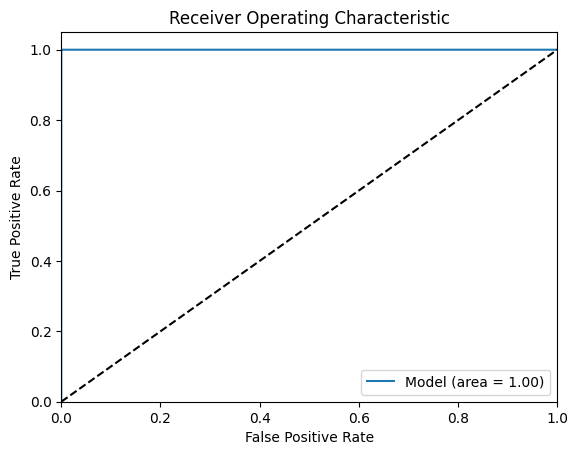

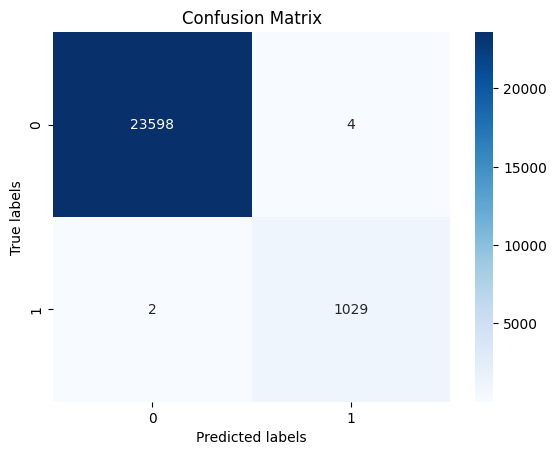

In [29]:
from lightgbm import LGBMClassifier

set_seed(SEED)
lgbm_model = LGBMClassifier(random_state=SEED)
lgbm_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
lgbm_model = train_and_evaluate_model(lgbm_model, lgbm_param_grid, X_train_resampled, X_test, y_train_resampled, y_test)

# Making Predictions on New Data

In [30]:
def predict_new_data(pipeline, new_data):
    classifier_name = pipeline.named_steps['classifier'].__class__.__name__
    new_predictions = pipeline.predict(new_data)
    print("Predictions for new data using", classifier_name, ":", new_predictions)
    
new_data = pd.DataFrame({
    'Current Assets': [233.211, 105.559, 63.971, 135.207, 82.589, 1.2164, 1.0049, 0.72926, 0.80974, 0.83593, 0.68673],
    'Net Income': [25.261, 129.688, -1.442, -20.401, -50.946, 1.281, 1.27, 1.0529, 1.1131, 1.0623, 1.0558],
    'EBIT': [31.521, 159.541, 13.994, 3.841, 2.061, 0.5251, 0.62288, 0.43292, 0.67546, 0.742, 0.77198],
    'Retained Earnings': [28.095, 157.783, 156.341, 135.941, 84.995, 0.18827, 0.18104, 0.044865, 0.091033, 0.0478, 0.043102],
    'Total Liabilities': [225.887, 880.327, 770.233, 776.697, 712.687, 0.022934, 0.0064542, -0.059379, -0.015229, 0.10702, 0.081916]
})


predict_new_data(rf_model, new_data)
predict_new_data(svm_model, new_data)
predict_new_data(gb_model, new_data)
predict_new_data(xgb_model, new_data)
predict_new_data(catboost_model, new_data)
predict_new_data(knn_model, new_data)
predict_new_data(nb_model, new_data)
predict_new_data(lr_model, new_data)
predict_new_data(dt_model, new_data)
predict_new_data(ada_model, new_data)
predict_new_data(lgbm_model, new_data)

Predictions for new data using RandomForestClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using SVC : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using GradientBoostingClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using XGBClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using CatBoostClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using KNeighborsClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using GaussianNB : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using LogisticRegression : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using DecisionTreeClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using AdaBoostClassifier : [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data using LGBMClassifier : [0 0 0 0 0 1 1 1 1 1 1]
